In [1]:
import subprocess
from subprocess import PIPE
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import glob
from scipy.stats import spearmanr

sys.path.append("../../funcs/")

import seaborn as sns
import proteomics as prot
import plotting as pl
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
PLOTS_DIR = "figures"
DATA_DIR = "../../data/processed/061721"
DATA_DIR_GC = "../../data/processed/061721_genecentric"
NMF_FILE = "../signatures/061721_imputed_res_reg/nmf_output.h5"
MAPPING_FILE = os.path.join(DATA_DIR, "PanCan_Participant_freeze_mapping.tsv")
LABELS = "../diffexp/061721_imputed_res_reg_dendro/full_dendro_sig_mappings.tsv"
OUT_DIR = "output"
GMT_DIR = "../../data/ref/gmts/"

os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

## 1. Load Matrices
---

In [3]:
samples_df = pd.read_csv(MAPPING_FILE, sep='\t')
labs_df = pd.read_csv(LABELS, sep='\t', index_col=0)
H_df = pd.read_hdf(NMF_FILE, "H")
meta_s = H_df.join(labs_df['cohort'])['cohort']
pmap_df = pd.read_csv(os.path.join(DATA_DIR, "var_map_full.tsv"), sep='\t', index_col=0)

/home/sanand/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,4,6,7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Load data matrices
rna_df = pd.read_parquet(os.path.join(DATA_DIR, "rna", "tumor_rna_tpm_norm_combat_X.parquet"))
prot_df = pd.read_csv(os.path.join(DATA_DIR_GC, "raw", "proteome_X.tsv.gz"), sep='\t', index_col=0)
phosph_df = pd.read_csv(os.path.join(DATA_DIR, "raw", "phosphoproteome_X.tsv.gz"), sep='\t', index_col=0)
acetyl_df = pd.read_csv(os.path.join(DATA_DIR, "raw", "acetylome_X.tsv.gz"), sep='\t', index_col=0)

# Subset appropriate samples
rna_df = rna_df[H_df.index]
prot_df = prot_df[H_df.index]
phosph_df = phosph_df[H_df.index]
acetyl_df = acetyl_df[np.intersect1d(H_df.index, acetyl_df.columns)]

In [5]:
rna_df.shape, acetyl_df.shape, prot_df.shape, phosph_df.shape

((29145, 1110), (30234, 572), (15699, 1110), (110274, 1110))

In [36]:
_prot_id = pd.DataFrame(prot_df.index, columns=['geneSymbol'])
_prot_id.index = _prot_id['geneSymbol']
_prot_id['feature'] = 'proteome'
_prot_id.index.name = 'id'

pmap_full_df = pd.concat([
    pmap_df,
    _prot_id
])

## 2. Correlations
---

#### Load gene sets

In [188]:
hmk_gmt = prot.pull_geneset_from_gmt(os.path.join(GMT_DIR, "h.all.v7.0.symbols.gmt.txt"))
staudt_gmt = prot.pull_geneset_from_gmt(os.path.join(GMT_DIR, "staudt_2020_filt.txt"))

fa_dict = {}
fa_dict["HALLMARK_FATTY_ACID_METABOLISM"] = prot.pull_geneset_from_gmt(
    os.path.join(GMT_DIR, "h.all.v7.0.symbols.gmt.txt"))["HALLMARK_FATTY_ACID_METABOLISM"]
fa_dict["HALLMARK_INTERFERON_GAMMA_RESPONSE"] = prot.pull_geneset_from_gmt(
    os.path.join(GMT_DIR, "h.all.v7.0.symbols.gmt.txt"))["HALLMARK_INTERFERON_GAMMA_RESPONSE"]
fa_dict["HALLMARK_INTERFERON_ALPHA_RESPONSE"] = prot.pull_geneset_from_gmt(
    os.path.join(GMT_DIR, "h.all.v7.0.symbols.gmt.txt"))["HALLMARK_INTERFERON_ALPHA_RESPONSE"]
fa_dict["KEGG_FATTY_ACID_METABOLISM"] = prot.pull_geneset_from_gmt(
    os.path.join(GMT_DIR, "c2.cp.kegg.v7.0.symbols.gmt.txt"))["KEGG_FATTY_ACID_METABOLISM"] 
fa_dict["KEGG_BIOSYNTHESIS_OF_UNSATURATED_FATTY_ACIDS"] = prot.pull_geneset_from_gmt(
    os.path.join(GMT_DIR, "c2.cp.kegg.v7.0.symbols.gmt.txt"))["KEGG_BIOSYNTHESIS_OF_UNSATURATED_FATTY_ACIDS"]
fa_dict["Regulatory_T cell_Newman"] = prot.pull_geneset_from_gmt(
    os.path.join(GMT_DIR, "staudt_2020_filt.txt"))["Regulatory_T cell_Newman"]

# All genes in the above gene-sets
gs = list()

for geneset in fa_dict.keys():
    gs += list(fa_dict[geneset])
    
gs = set(gs)

In [192]:
# Example usage
prot.m_corr_compute(
    rna_df, prot_df, ['IL7R','GZMA', 'GZMB'], pmap_full_df, verbose=True
)

Running correlations: 100%|██████████| 3/3 [00:00<00:00, 62.58it/s]

 * 3 feats in A
 * 3 feats in B


,a,a_gene,a_feature,b,b_gene,b_feature,rho,pval,a_frac,b_frac
0,ENSG00000100453.13,GZMB,transcriptome,GZMA,GZMA,proteome,0.356705,0.0,1.0,0.999099
1,ENSG00000145649.8,GZMA,transcriptome,GZMA,GZMA,proteome,0.543255,0.0,1.0,0.999099
2,ENSG00000168685.15,IL7R,transcriptome,GZMA,GZMA,proteome,0.188626,0.0,1.0,0.999099
3,ENSG00000100453.13,GZMB,transcriptome,GZMB,GZMB,proteome,0.663886,0.0,1.0,0.282883
4,ENSG00000145649.8,GZMA,transcriptome,GZMB,GZMB,proteome,0.551628,0.0,1.0,0.282883
5,ENSG00000168685.15,IL7R,transcriptome,GZMB,GZMB,proteome,0.214412,0.000129,1.0,0.282883
6,ENSG00000100453.13,GZMB,transcriptome,IL7R,IL7R,proteome,0.092889,0.298944,1.0,0.114414
7,ENSG00000145649.8,GZMA,transcriptome,IL7R,IL7R,proteome,0.039423,0.6599,1.0,0.114414
8,ENSG00000168685.15,IL7R,transcriptome,IL7R,IL7R,proteome,0.368749,0.00002,1.0,0.114414


#### Run all correlations
* Takes ~ 45 mins

In [92]:
fa_corr = dict()

fa_corr['rna_prot'] = prot.m_corr_compute(rna_df, prot_df, gs, pmap_full_df, a_filt=0.5, b_filt=0.5)
fa_corr['prot_phosph'] = prot.m_corr_compute(prot_df, phosph_df, gs, pmap_full_df, a_filt=0.5, b_filt=0.5)
fa_corr['prot_acetyl'] = prot.m_corr_compute(prot_df, acetyl_df, gs, pmap_full_df, a_filt=0.5, b_filt=0.5)
fa_corr['rna_phosph'] = prot.m_corr_compute(rna_df, phosph_df, gs, pmap_full_df, a_filt=0.5, b_filt=0.5)
fa_corr['rna_acetyl'] = prot.m_corr_compute(rna_df, acetyl_df, gs, pmap_full_df, a_filt=0.5, b_filt=0.5)

for key in fa_corr.keys():
    fa_corr[key]['comp'] = key
fa_corr_df = pd.concat(fa_corr.values())

100%|██████████| 457/457 [14:53<00:00,  1.95s/it]


#### Add Gene-set Types

In [105]:
fa_list = ['HALLMARK_FATTY_ACID_METABOLISM','KEGG_FATTY_ACID_METABOLISM','KEGG_BIOSYNTHESIS_OF_UNSATURATED_FATTY_ACIDS']
fa_gs = list()

for geneset in fa_list:
    fa_gs += list(fa_dict[geneset])
    
fa_gs = set(fa_gs)
treg_gs = set(fa_dict["Regulatory_T cell_Newman"])
ifg_gs = set(fa_dict["HALLMARK_INTERFERON_GAMMA_RESPONSE"])
ifa_gs = set(fa_dict["HALLMARK_INTERFERON_ALPHA_RESPONSE"])

def _get_gene_type(x):
    res = list()
    
    if x in fa_gs:
        res.append("FA_metabolism")
    elif x in treg_gs:
        res.append("T_reg")
    elif x in ifg_gs:
        res.append("IFN_gamma")
    elif x in ifa_gs:
        res.append("IFN_alpha")
    return res[0]

fa_corr_df['a_geneset'] = fa_corr_df['a_gene'].apply(lambda x: _get_gene_type(x))
fa_corr_df['b_geneset'] = fa_corr_df['b_gene'].apply(lambda x: _get_gene_type(x))

In [127]:
fa_corr_df.to_parquet(os.path.join(OUT_DIR, "fa_corr.parquet"))
fa_corr_df.to_csv(os.path.join(OUT_DIR, "fa_corr.tsv"), sep="\t")

In [128]:
# Plots

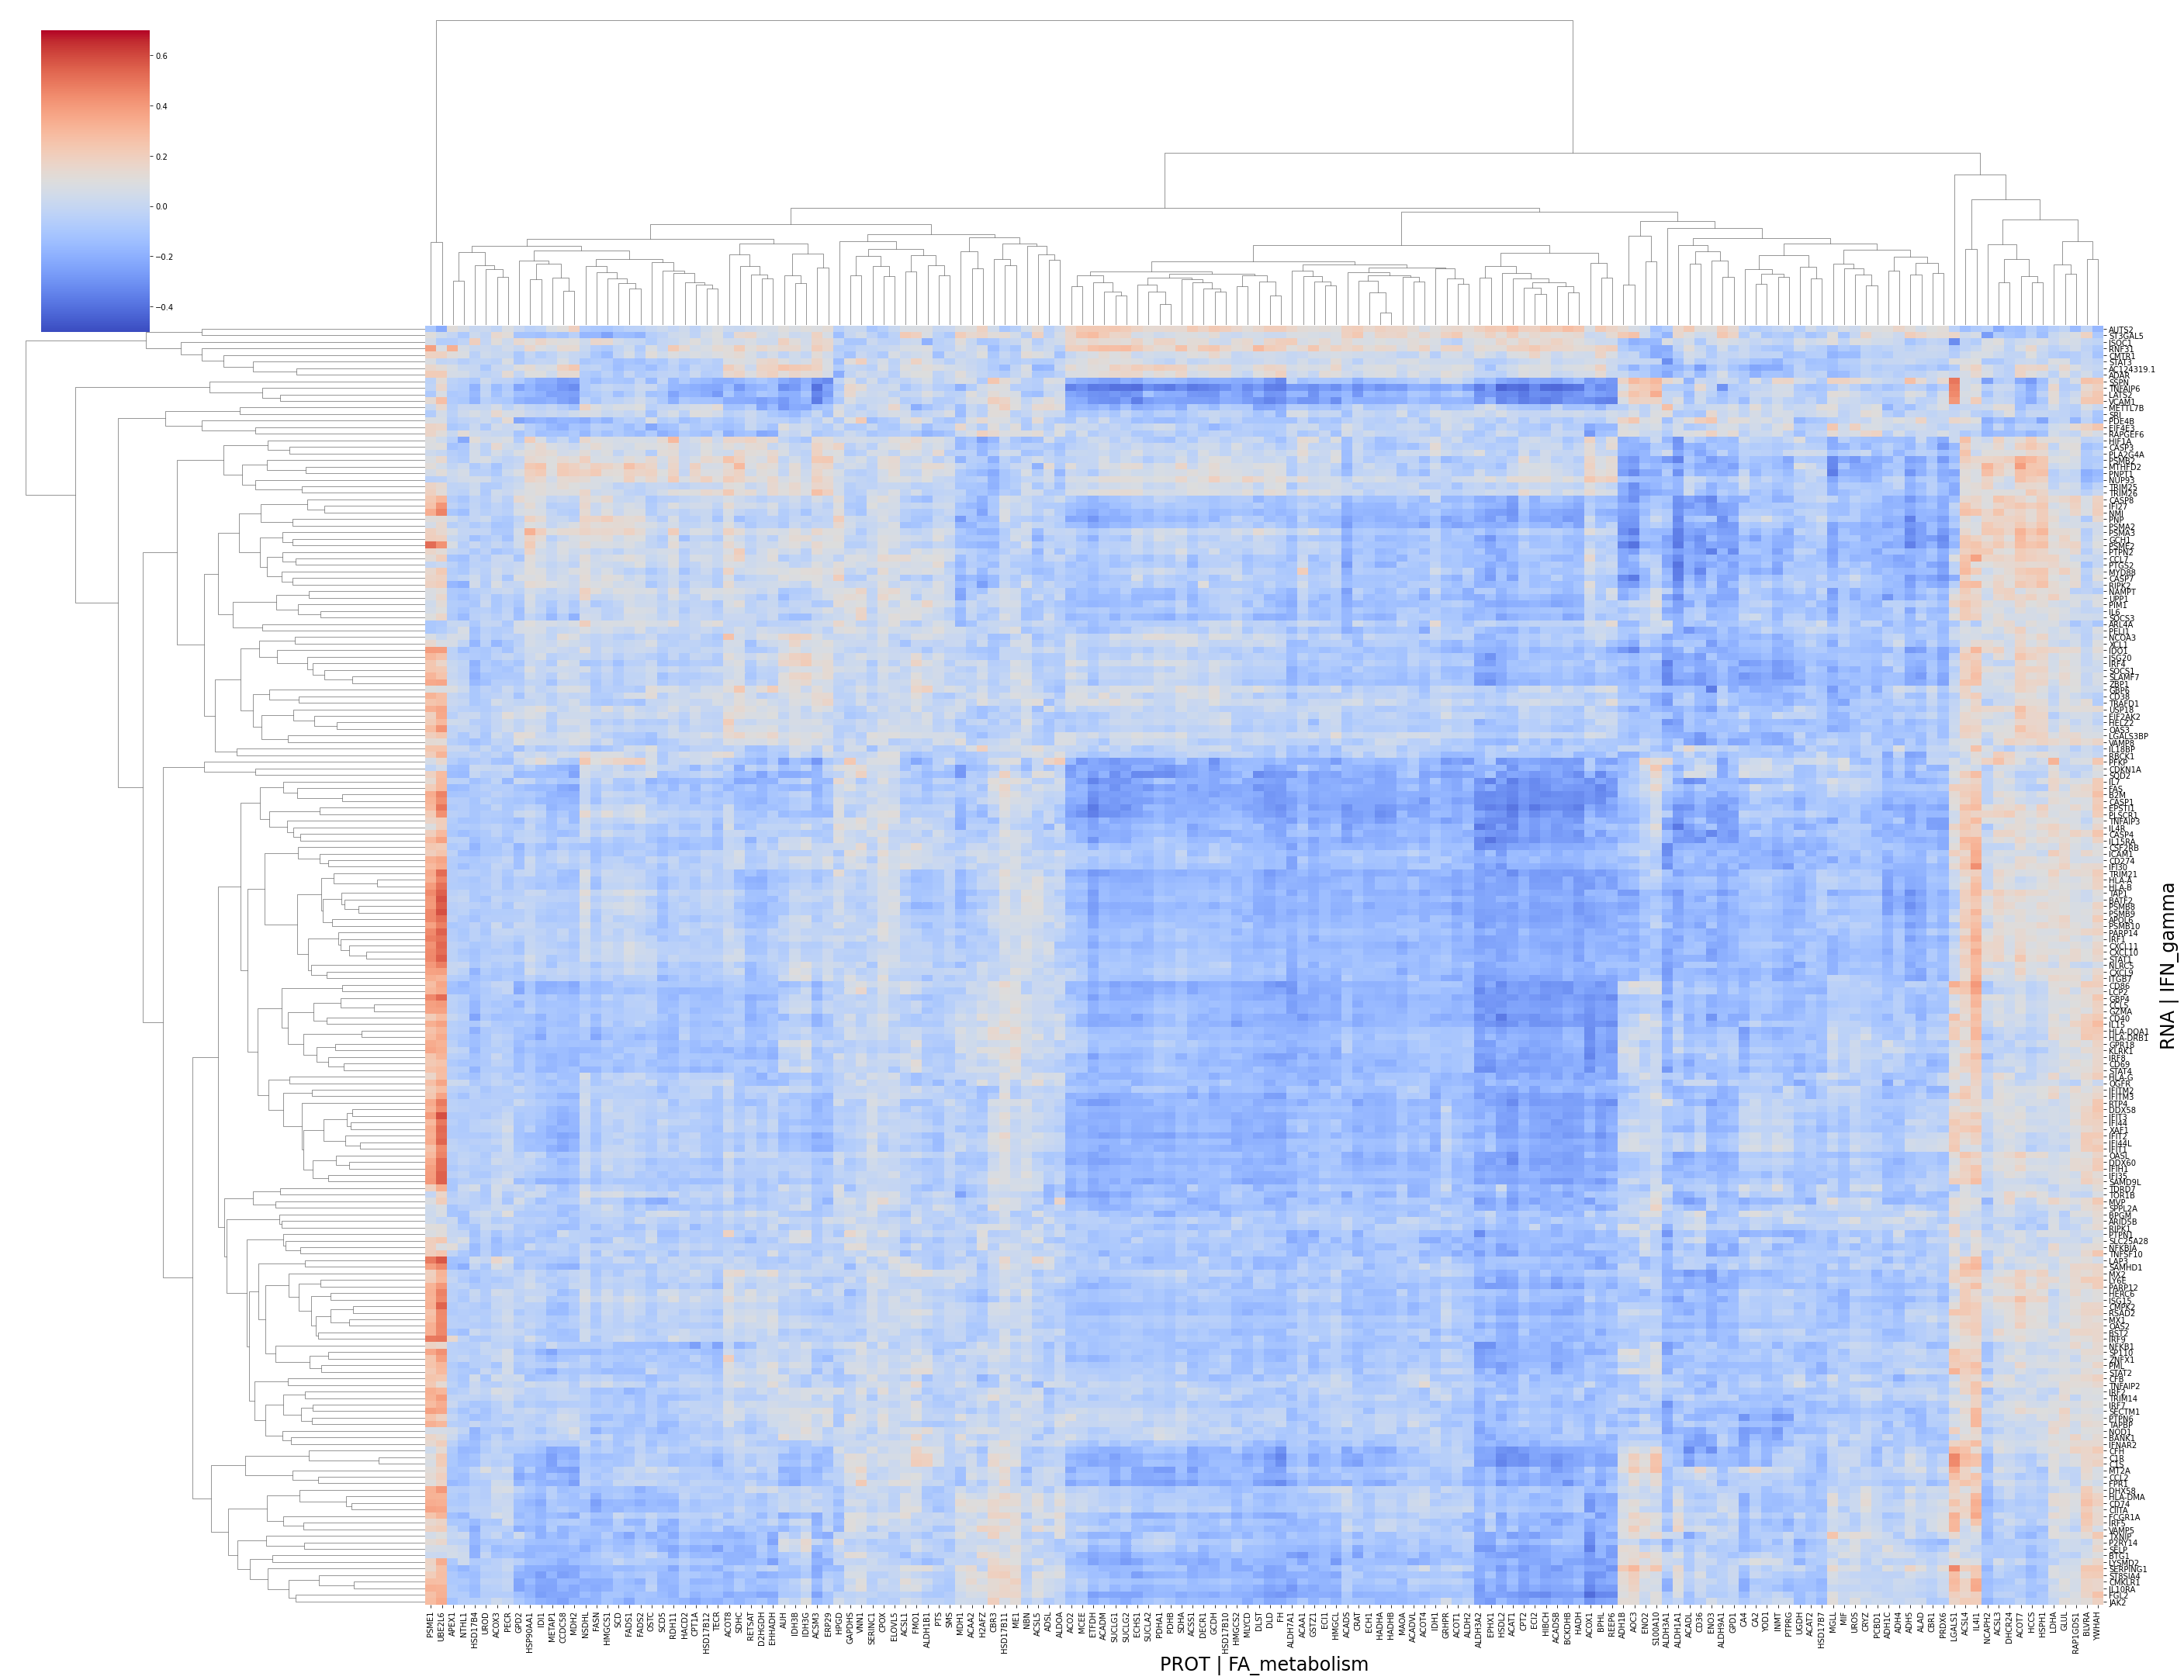

In [199]:
pl.corr_clustermap(fa_corr_df, "rna_prot", "IFN_gamma", "FA_metabolism")
plt.savefig(os.path.join(PLOTS_DIR, "rna_prot_ifngamma_fametab.pdf"), dpi=100, bbox_inches='tight')